In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, sys, re
from glob import glob
import subprocess

from collections import Counter
from itertools import chain
from functools import partial

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Load Data
Files to load: all (`os.listdir` with model specified) vs specific list

Note: `reference` might also contain non test files - filter out

In [63]:
def name_adapt(s:str, extra_patterns:list=[]):
    extra_patterns += ['finetuned', '.csv']
    for p in extra_patterns:
        s = s.replace(p,'')
    # replace adjacent '-' / '_' with only one
    return re.sub('[-_]{1,}','-',s).split('/')[-1]


In [70]:
dataset = "hcrc_maptask"
data_folder = f"../data/{dataset}/*/*.csv"
gf_reference = "gpt2-en-maptask-finetuned-maptask-fin" #"gpt2-en-maptask-finetuned_file_1024.csv"
model_patterns = ['rnn', 'gpt','srilm']
data_paths = {
    ("reference" if gf_reference in x else name_adapt(x,["maptask"])):x for x in glob(data_folder) if any([y in x.lower() for y in model_patterns]) and ('_old' not in x) # os.listdir(data_folder)
}

In [71]:
gpt_ctx_nopivot = [k for k,v in data_paths.items() if 'c0-8.csv' in v]
if len(gpt_ctx_nopivot) > 0:
    gpt_c08l = pd.read_csv(data_paths.pop(gpt_ctx_nopivot[0]))
data_paths

{'rnn-ft-mp2-': '../data/hcrc_maptask/res_rnn/rnn_ft_mp2-maptask.csv',
 'rnn-ft-mp2-c0-8-p': '../data/hcrc_maptask/res_rnn/rnn_ft_mp2-maptask_c0-8-p.csv',
 'gpt2-en-c0-8': '../data/hcrc_maptask/res_gpt2-en/gpt2-en-maptask-finetuned-maptask-c0-8.csv',
 'gpt2-en-c0-8-p': '../data/hcrc_maptask/res_gpt2-en/gpt2-en-maptask-finetuned-maptaskc0-8-p.csv',
 'gpt2-en-sep': '../data/hcrc_maptask/res_gpt2-en/gpt2-en-maptask-finetuned-maptask-sep.csv',
 'reference': '../data/hcrc_maptask/res_gpt2-en/gpt2-en-maptask-finetuned-maptask-fin.csv',
 '-v2.1-srilm-LM-EN-nopretrain': '../data/hcrc_maptask/res_srilm/maptask-v2.1_srilm-LM_EN_nopretrain.csv',
 '-v2.1-srilm-LM-EN-pretrain': '../data/hcrc_maptask/res_srilm/maptask-v2.1_srilm-LM_EN_pretrain.csv',
 '-v2.1-srilm-LM-EN-swb': '../data/hcrc_maptask/res_srilm/maptask-v2.1_srilm-LM_EN_swb.csv',
 '-v2.1-srilm-LM-EN-pret-swb': '../data/hcrc_maptask/res_srilm/maptask-v2.1_srilm-LM_EN_pret_swb.csv',
 '-v2.1-srilm-LM-EN-wiki1pt': '../data/hcrc_maptask/res_sr

In [101]:
df = {}
srilm_cols = ['test_text','sent_index','nb_oov','pred_tokens','sum_logp','perplexity','perplexity_no-eos']
for k,v in data_paths.items():
    tmp = pd.read_csv(v)
    model_pat = [y for y in model_patterns if y in v.lower()][0] # necessarily not empty bc of prev selection
    if 'model' not in tmp.columns: # typically: reference
        tmp['model'] = k
    else: # adding for _x context, problem when rnn/gpt have both
        tmp['model'] = tmp['model'].apply(lambda x: f'{model_pat}{x}' if model_pat not in x else x)
    
    # specific to srilm models
    if 'srilm' in k:
        tmp['sum_h'] = tmp['sum_logp']
        tmp['tokens'] = tmp['pred_tokens']
        tmp = tmp[[col for col in tmp.columns if col not in srilm_cols]]
    
    df[k] = tmp

res = pd.concat(df.values(), axis=0)

In [102]:
models = res.model.unique()
models

array(['rnn-ft-mp2-', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4',
       'rnn_5', 'rnn_6', 'rnn_7',
       'gpt2-en-maptask-finetuned-context_full_sep_eos', 'gpt_0', 'gpt_1',
       'gpt_2', 'gpt_3', 'gpt_4', 'gpt_5', 'gpt_6', 'gpt_7',
       'gpt2-en-maptask-finetuned-context_full_sep_space', 'reference',
       'srilm-LM_EN_nopretrain', 'srilm-LM_EN_pretrain',
       'srilm-LM_EN_swb', 'srilm-LM_EN_pret_swb', 'srilm-LM_EN_wiki1pt'],
      dtype=object)

Removing files not analysed for every model:

In [103]:
#if 'reference' in res.model.unique():
#    test_files = res[res.model != 'reference'].file.unique()
#    res = res[res.file.isin(test_files)]
res_files = Counter(chain(*[res[res.model == model].file.unique() for model in res.model.unique()]))
res_files = [k for k,v in res_files.items() if v == len(models)]
res = res[res.file.isin(res_files)]

In [104]:
res.isna().sum(axis=0)

file                     0
speaker                  0
theme_id                 0
transaction_type         0
move_number              0
move_type                0
index                    0
theme_index              0
duration                 0
text                     0
context              71388
text_u              134844
normalised_h          3656
length                   0
tokens_h                 0
sum_h                 3656
tokens                   0
xu_h                  3656
model                    0
dtype: int64

In [82]:
res.head()

,file,speaker,theme_id,transaction_type,move_number,move_type,index,theme_index,duration,text,context,text_u,normalised_h,length,tokens_h,sum_h,tokens,xu_h,model
0,q1ec1,g,1,normal,1,ready,1,1,0.3294,okay,okay,okay,2.369664,2,"[-4.739068031311035, -0.0002600143488962203]",4.739328,"['ok', 'ay']",0.476333,rnn-ft-mp2-
1,q1ec1,g,1,normal,2,instruct,2,2,3.1785,starting off we are above a caravan park,okay starting off we are above a caravan park,starting off we are above a caravan park,8.448545,8,"[-13.469964027404785, -8.786431312561035, -14....",67.588357,"['starting', ' off', ' we', ' are', ' above', ...",1.522796,rnn-ft-mp2-
2,q1ec1,f,1,normal,1,acknowledge,3,3,0.3459,mmhmm,okay starting off we are above a caravan park ...,mmhmm,1.650264,3,"[-4.910094738006592, -0.006692978087812662, -0...",4.950793,"['mm', 'h', 'mm']",0.314559,rnn-ft-mp2-
3,q1ec1,g,1,normal,3,instruct,4,4,9.7612,we are going to go due south straight south an...,okay starting off we are above a caravan park ...,we are going to go due south straight south an...,6.207687,33,"[-11.97866153717041, -11.164701461791992, -5.5...",204.853666,"['we', ' are', ' going', ' to', ' go', ' due',...",1.116201,rnn-ft-mp2-
4,q1ec1,f,1,normal,2,check,5,5,1.5487,due south and then back up again,okay starting off we are above a caravan park ...,due south and then back up again,5.405318,7,"[-17.88815689086914, -3.532069683074951, -2.99...",37.837228,"['due', ' south', ' and', ' then', ' back', ' ...",0.989931,rnn-ft-mp2-


In [46]:
length_by_file = res.groupby('file')['index'].max().to_dict()

## Plots

### Checking consistency

In [83]:
reference_name = 'reference'#'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'#'reference'

In [105]:
models = res.model.unique()
merge_cols = ['file', 'index', 'speaker', 'text']
int_cols = ['normalised_h', 'xu_h', 'length']
cols = merge_cols + int_cols
comparison_df = {}
if reference_name in models:
    ref = res[res.model == reference_name][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod')).dropna(axis=0, subset=['xu_h_mod'])
        print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
        comparison_df[model] = c
    

Correlation for model rnn-ft-mp2-: normalised_h 0.31581424447339507 - xu_h 0.6470564748463148
Correlation for model rnn_0: normalised_h 0.49836640554575123 - xu_h 0.6502390953028868
Correlation for model rnn_1: normalised_h 0.5906809650787729 - xu_h 0.6182147252064669
Correlation for model rnn_2: normalised_h 0.6106057669156509 - xu_h 0.6323973418918655
Correlation for model rnn_3: normalised_h 0.616394265682806 - xu_h 0.6385828546643015
Correlation for model rnn_4: normalised_h 0.6177247357314073 - xu_h 0.6404343310788387
Correlation for model rnn_5: normalised_h 0.6181641505817875 - xu_h 0.6413214687340679
Correlation for model rnn_6: normalised_h 0.617272096553406 - xu_h 0.6410303586703101
Correlation for model rnn_7: normalised_h 0.6167566804744178 - xu_h 0.6406140470549594
Correlation for model gpt2-en-maptask-finetuned-context_full_sep_eos: normalised_h 1.0 - xu_h 1.0
Correlation for model gpt_0: normalised_h 0.8212978015770528 - xu_h 0.8324639215359928
Correlation for model gpt_

In [106]:
xu_corr_results = {model:{} for model in models}
nh_corr_results = {model:{} for model in models}
for reference_model in models:
    ref = res[res.model == reference_model][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod')).dropna(axis=0, subset=['xu_h_mod'])
        xu_corr_results[reference_model][model] = c.xu_h_ref.corr(c.xu_h_mod)
        nh_corr_results[reference_model][model] = c.normalised_h_ref.corr(c.normalised_h_mod)

xu_corr_results = pd.DataFrame(xu_corr_results)
nh_corr_results = pd.DataFrame(nh_corr_results)

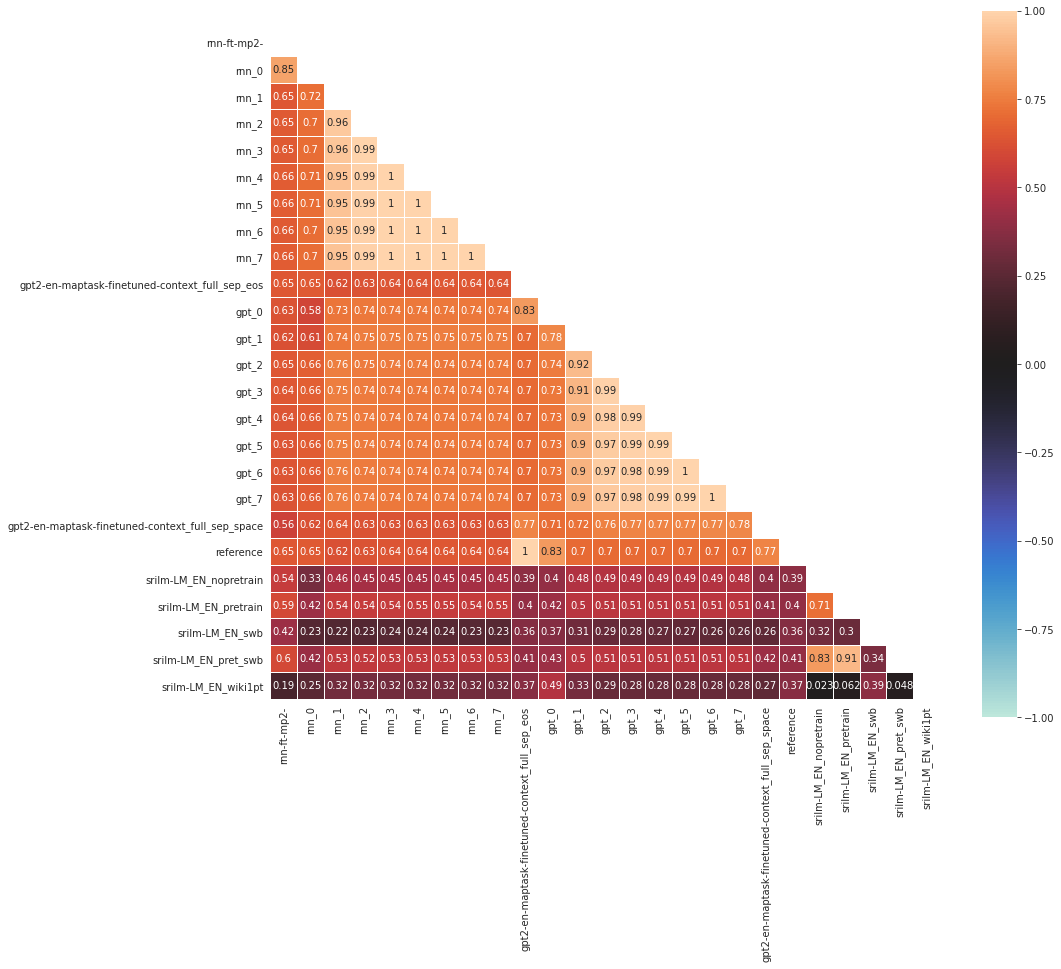

In [108]:
mask = np.zeros_like(xu_corr_results)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 13))
    ax = sns.heatmap(xu_corr_results, mask=mask, vmax=1., vmin=-1., square=True,linewidths=.5,annot=True, center=0)

In [110]:
#comparison_name = 'microsoft-dialogpt-small-context_<|endoftext|>100—bs8'
comparison_name = 'gpt2-en-maptask-finetuned-context_full_sep_space'
#comparison_name = 'microsoft-dialogpt-ds-test'
#comparison_name = 'gpt2-en-maptask-file-1024'

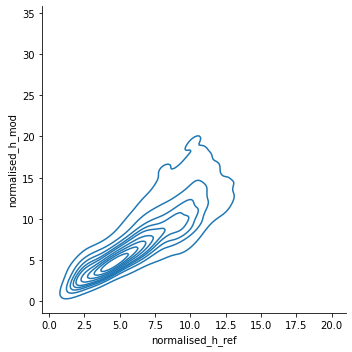

In [111]:
#sns.displot(data=comparison_df['gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'], x="normalised_h_ref", y="normalised_h_mod", kind="kde")
sns.displot(data=comparison_df[comparison_name], x="normalised_h_ref", y="normalised_h_mod", kind="kde")

#### Potential errors: lines with different numbers of tokens
And removing lines for which tokenizer leads to different results:

In [87]:
c = comparison_df[comparison_name]
err = c[c.length_ref != c.length_mod]
c = c[c.length_ref == c.length_mod]

number of lines unaffected: 0.9968426370295529


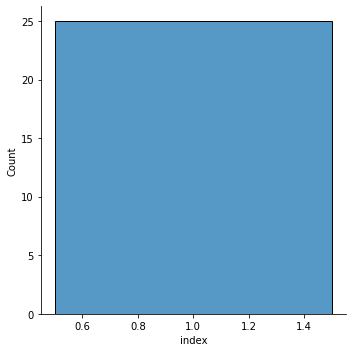

In [88]:
print(f'number of lines unaffected: {c.shape[0]/comparison_df[comparison_name].shape[0]}')
sns.displot(data=err, x='index', kind='hist')

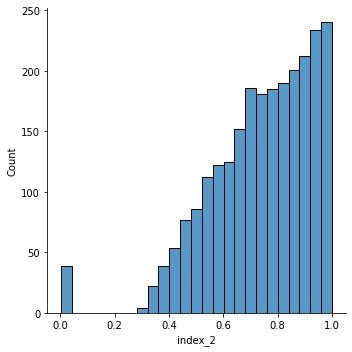

In [49]:
err['index_2'] = err.apply(lambda x: x['index'] / length_by_file[x['file']], axis=1)
sns.displot(data=err, x='index_2', kind='hist')

Percentage of files: 0.3023255813953488


<AxesSubplot:ylabel='Frequency'>

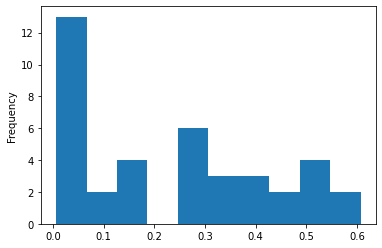

In [55]:
files_with_err = (err.groupby('file').count()['index'] / pd.Series(length_by_file))
print('Percentage of files:', files_with_err.dropna().shape[0]/files_with_err.shape[0])
files_with_err.dropna().plot.hist()

#### Correlation

Correlation for model srilm-LM_EN_wiki1pt: normalised_h 0.8423635341442792 - xu_h 0.7731906985178704


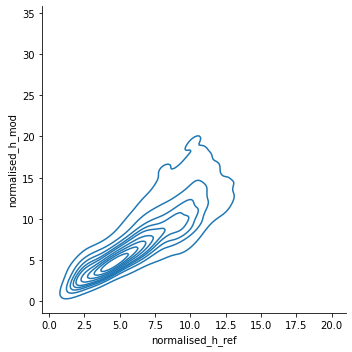

In [112]:
c = comparison_df[comparison_name]
print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
sns.displot(data=c, x="normalised_h_ref", y="normalised_h_mod", kind="kde")

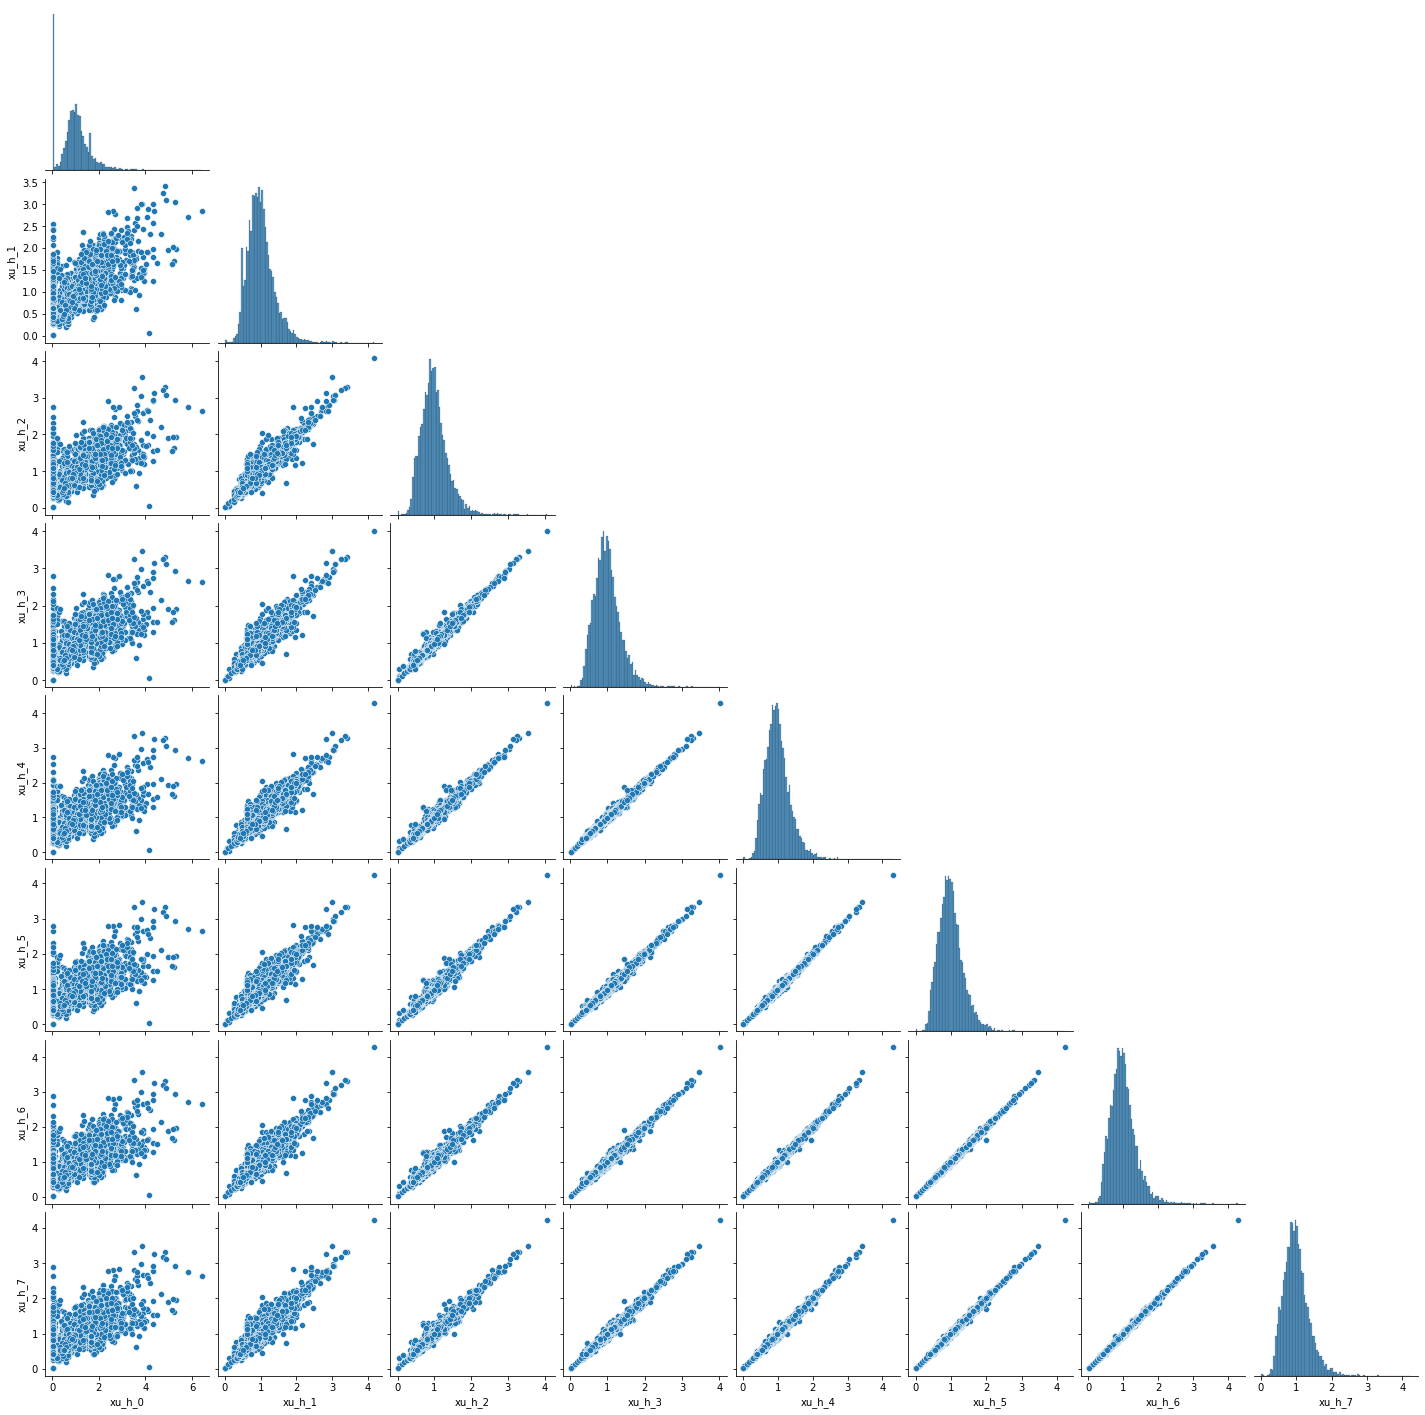

In [89]:
sns.pairplot(gpt_c08l, vars = [f'xu_h_{i}' for i in range(0,8)], corner=True)
plt.show()

### Generals

In [113]:
# keep for study
dialogs = res[res.model.isin([reference_name, comparison_name])]

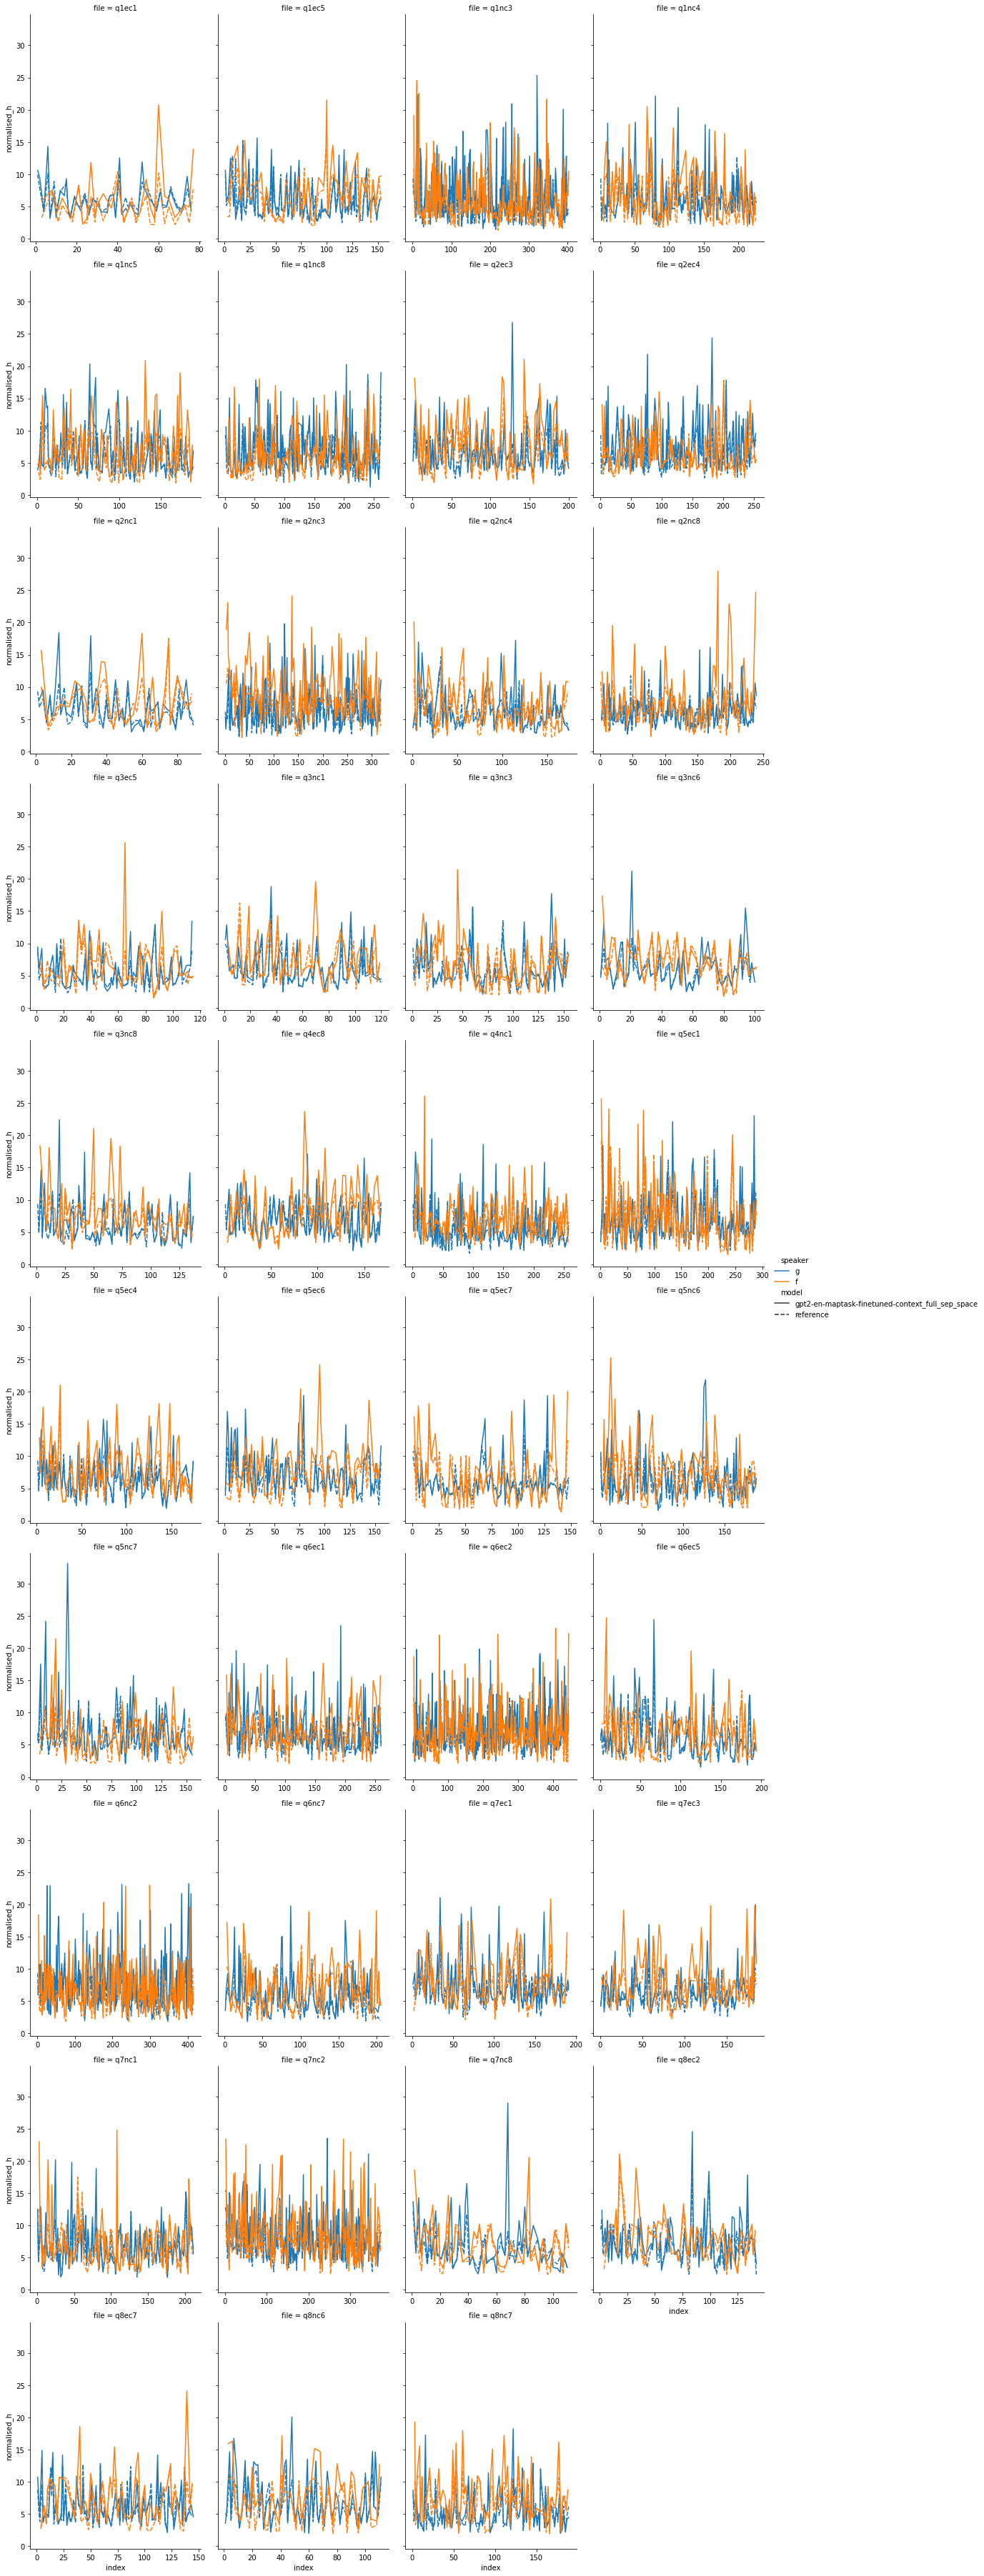

In [114]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

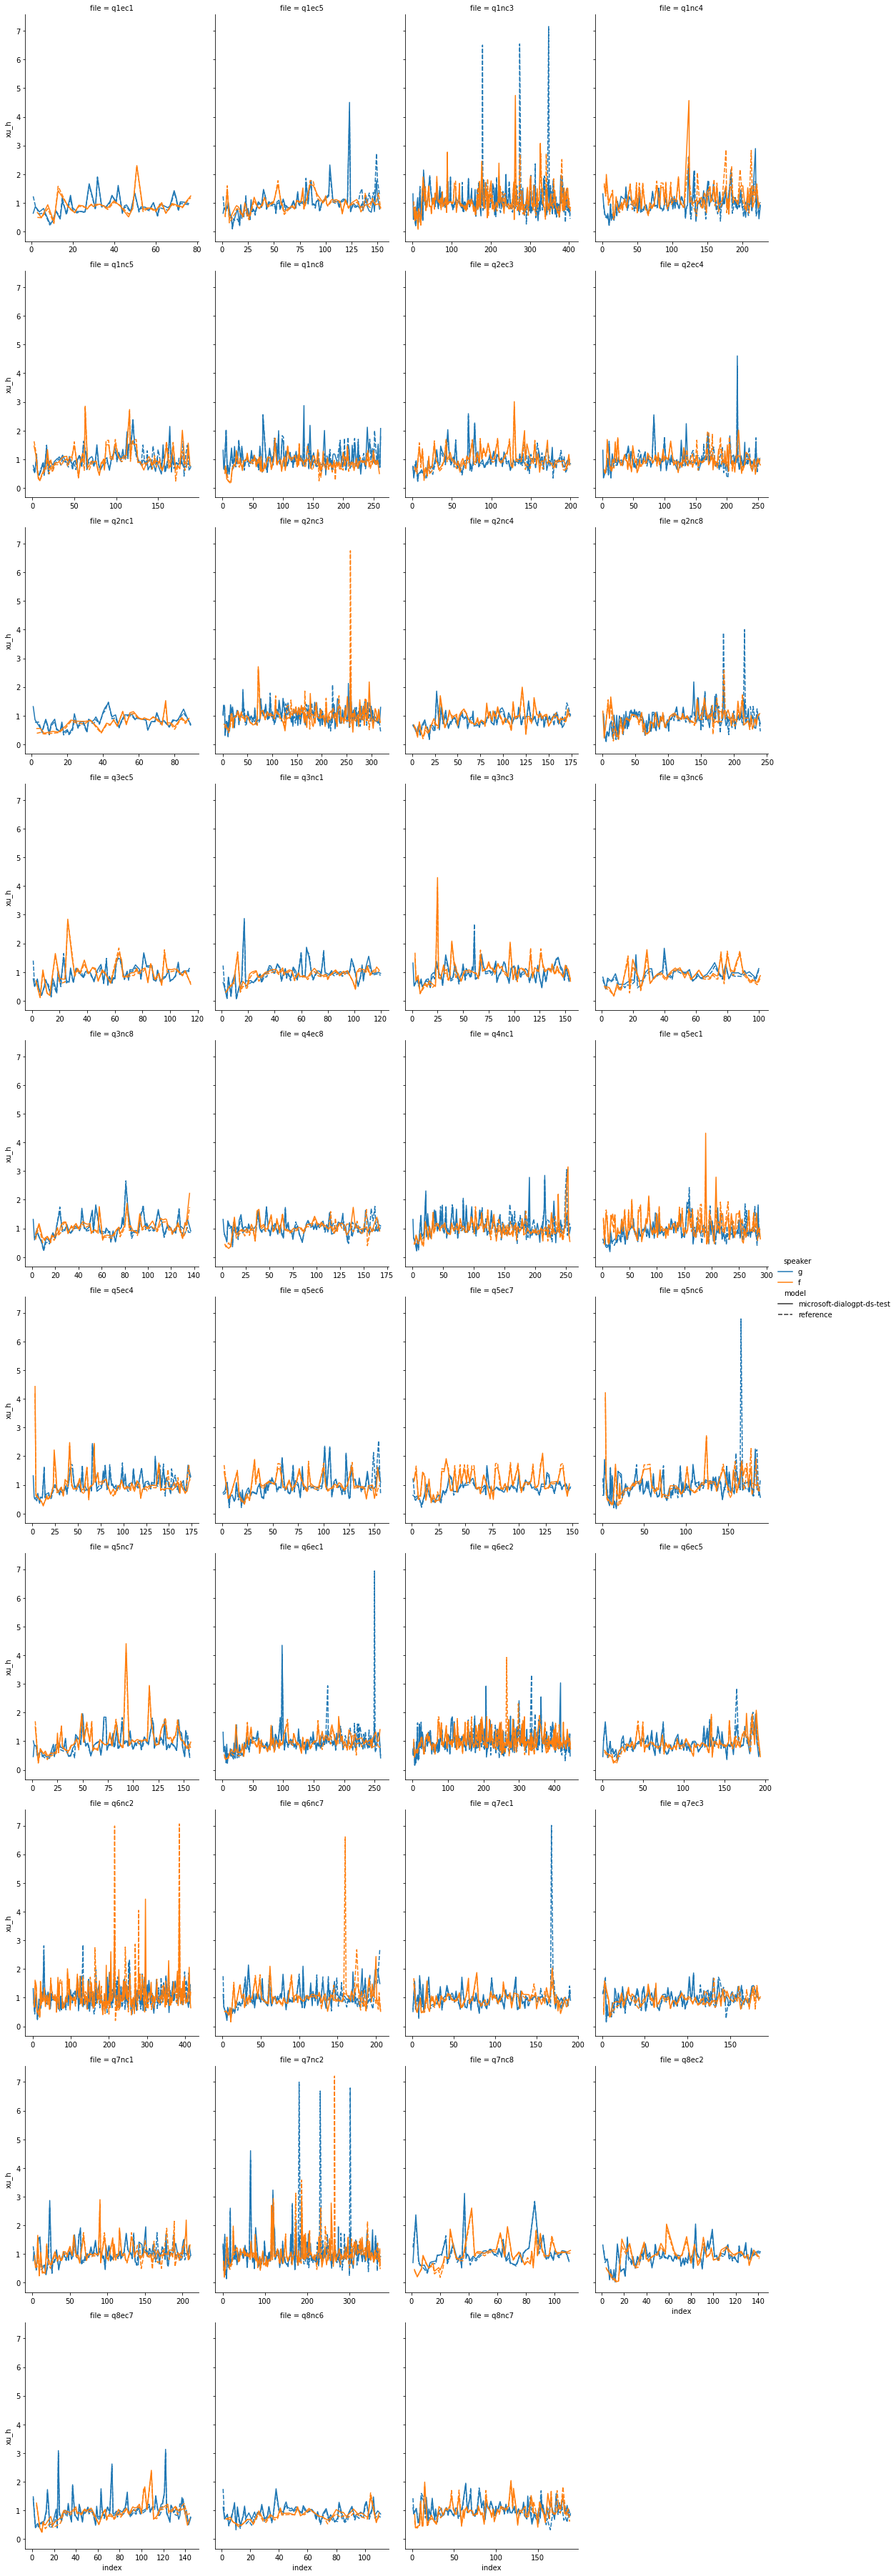

In [113]:
sns.relplot(
    data=dialogs,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

### By episodes

Number of themes by file?

In [115]:
has_id_themes = 'theme_id' in dialogs.columns
theme_col = 'theme' if not has_id_themes else 'theme_id'

<AxesSubplot:ylabel='Density'>

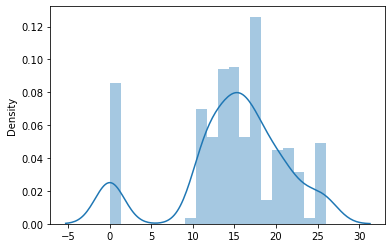

In [116]:
sns.distplot(dialogs.drop_duplicates(subset=['file',theme_col]).groupby('file').count())

In [117]:
# For the 2nd one: reindex => take the sign * max number
# Remove lines with extra transitions then for each one take the lines before / after and index and concat
# Note: issue with duplicated themes
not_transition = (dialogs[theme_col] != 'transition').astype(int)
#dialogs = dialogs[dialogs.theme != 'transition']
dialogs['theme_id'] = (dialogs[theme_col] != dialogs[theme_col].shift()).cumsum()
nb_in_ep = dialogs.groupby(['file', 'theme_id']).agg({'index': lambda x: range(len(x))}).explode('index')['index'].to_list()
inv_nb_in_ep = dialogs.groupby(['file', 'theme_id']).agg({'index': lambda x: range(-len(x),0)}).explode('index')['index'].to_list()
dialogs['count_after'] = nb_in_ep * not_transition
dialogs['count_before'] =  inv_nb_in_ep * not_transition

In [118]:
def compute_transitions_df(dialogs:pd.DataFrame, min_idx:int=10, max_idx:int=40, theme_col='theme'):
    # TODO: add checks on columns
    # remove_transitions
    dialogs = dialogs[dialogs[theme_col] != 'transition'].reset_index(drop=True)
    # get lines with 0
    new_themes = dialogs[dialogs.count_after == 0]
    if dialogs[theme_col].dtypes != int:
        new_themes['theme_id'] = range(new_themes.shape[0])

    final_df = []
    for idx, row in new_themes.iterrows():
        tmp = dialogs.iloc[max(0,idx-min_idx):min(dialogs.shape[0],idx+max_idx)]
        tmp['index'] = range(max(-min_idx,-idx), min(max_idx,dialogs.shape[0] - idx))
        # no need to check on file / model, done automatically
        tmp['ba'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else x.count_before, axis=1)
        tmp = tmp[tmp['index'] == tmp.ba]
        if dialogs[theme_col].dtypes != int:
            tmp['theme_id'] = row.theme_id
        # Add for plotting
        tmp['count_after'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else np.nan, axis=1)
        tmp['count_before'] = tmp.apply(lambda x: x.count_before if x['index'] <= 0 else np.nan, axis=1)
        # Add initiator / responder
        tmp['is_initiator'] = (tmp.speaker == row.speaker)
        # Add to df
        final_df.append(tmp)

    final_df = pd.concat(final_df, ignore_index=True)
    final_df['is_initiator'] = final_df.is_initiator.apply(lambda x: x * 'initiator' + (1 - x) * 'responder')
    return final_df

In [119]:
final_df = compute_transitions_df(dialogs, min_idx=5, max_idx=10, theme_col = theme_col)
final_df.shape

(16033, 23)

In [120]:
target_col = "normalised_h"

Differenciating between initiators and responders 

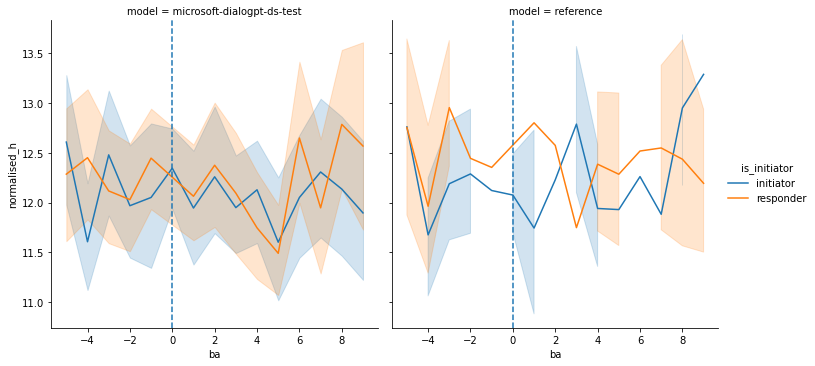

In [119]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Graph we want: apply `statsmodel` _before 0_ and _after 0_ and plot it on the same graph (with a scatterplot for the values)

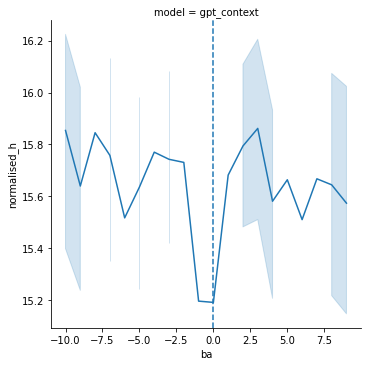

In [27]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model')
model_memory = {model:{} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        tmp = final_df[final_df.model == model].dropna(subset=[col])
        x = np.array([tmp['index'].min(), tmp['index'].max()])
        reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
        #print(model, col, reg_model.params) # .summary() for full summary of model
        g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], 'b')
        model_memory[model][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


In [120]:
target_col = "xu_h"

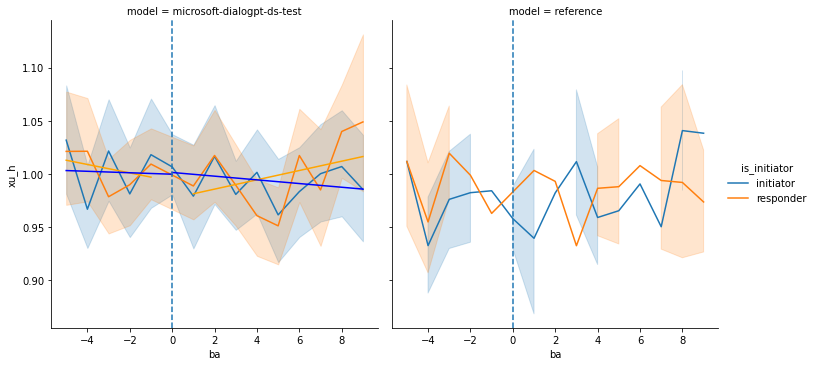

In [121]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
model_memory = {model:{spk:{} for spk in ['initiator','responder']} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        for spk, c in zip(['responder', 'initiator'], ['orange', 'b']):
            tmp = final_df[(final_df.model == model) & (final_df.is_initiator == spk)].dropna(subset=[col])
            x = np.array([tmp['index'].min(), tmp['index'].max()])
            reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
            #print(model, col, reg_model.params) # .summary() for full summary of model
            g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], c)
            model_memory[model][spk][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


Investigating a given model:
```python
for spk in ['initiator', 'responder']:
    print(f"\n-------------------{spk.upper()}------------------")
    print(model_memory['gpt_context'][spk]['count_after'].summary())
```

#### Data Exploration for one sentence

In [103]:
res[res.text == 'mh ouais si tu veux'][[col for col in res.columns if 'context_' not in col]]

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,has_theme,h,normalised_h,length,tokens_h,tokens,xu_h,model,text_u,sum_h
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,28.442576,4.063225,7,"[-11.516682624816895, -0.17777733504772186, -3...","['m', 'h', 'Ġou', 'ais', 'Ġsi', 'Ġtu', 'Ġveux']",0.864351,reference,NaN,NaN
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.212218,7,"[-11.058761596679688, -2.373636484146118, -3.6...",4.147299,0.646360,gpt_context_0,mh ouais si tu veux,29.485528
3817,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147302,7,"[-10.792609214782715, -0.26334744691848755, -4...",4.147299,0.822468,gpt_context_1,mh ouais si tu veux,29.031112
7633,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147304,7,"[-10.79261589050293, -0.2633468508720398, -4.2...",4.147299,0.842557,gpt_context_2,mh ouais si tu veux,29.031125
11449,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.263347864151001, -4.2...",4.147299,0.844409,gpt_context_3,mh ouais si tu veux,29.031081
15265,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.26334843039512634, -4...",4.147299,0.846863,gpt_context_4,mh ouais si tu veux,29.031081
19081,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147301,7,"[-10.792603492736816, -0.26334670186042786, -4...",4.147299,0.847680,gpt_context_5,mh ouais si tu veux,29.031104
22897,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.848037,gpt_context_6,mh ouais si tu veux,29.031096
26713,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.849066,gpt_context_7,mh ouais si tu veux,29.031096
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792593002319336, -0.2633475661277771, -4....",4.147297,0.851300,gpt2-fr-paco-cheese-finetuned-context_ 000—bs1,mh ouais si tu veux,29.031082


In [97]:
tmp = comparison_df[comparison_name].dropna()

In [98]:
tmp['normalised_h_diff'] = (tmp.normalised_h_ref - tmp.normalised_h_mod).abs()/tmp.normalised_h_ref

In [99]:
tmp.sort_values(by='normalised_h_diff', ascending=False).head(20)

,file,index,speaker,text,normalised_h_ref,xu_h_ref,length_ref,normalised_h_mod,xu_h_mod,length_mod,normalised_h_diff
2363,q2nc8,17,f,okay,1.334070,0.117511,2.0,8.997726,0.855204,2.0,5.744568
5868,q6nc2,217,f,i've got the sort of basic shape anyway so i s...,2.322731,0.200281,1.0,12.382504,1.002969,19.0,4.331012
2149,q2nc3,296,f,"is it an u-- an u-- a ""u""-turn or a",5.891948,0.508042,1.0,28.133431,2.175590,15.0,3.774895
6608,q7ec3,145,g,i've got lime stone cliffs which is the bottom...,3.211297,0.276899,1.0,14.192241,1.071566,25.0,3.419474
7907,q8nc7,165,g,over the summit down the right-hand side of it...,3.759123,0.324136,1.0,15.234112,1.284239,14.0,3.052571
5877,q6nc2,226,f,uh-huh right,6.571548,0.566641,1.0,24.296775,1.979734,5.0,2.697268
7225,q7nc2,366,g,go to the right about an inch and then draw an...,5.003920,0.409269,3.0,16.967571,1.374354,19.0,2.390856
802,q1nc4,169,g,the canal is about two inches to the left-hand...,4.176884,0.360158,1.0,13.837277,1.136265,22.0,2.312823
520,q1nc3,291,g,well you should curve just you you'll have to ...,3.007655,0.259339,1.0,9.717919,0.806383,13.0,2.231062
2143,q2nc3,290,f,acr-- right,9.497540,0.818939,1.0,28.709291,1.560835,4.0,2.022813


In [101]:
file = 'q2nc8'
idx = 17
ba = 4

cond = (res.file == file) & (res['index'] >= idx-ba) & (res['index'] <= idx+ba) & (res.model.isin([reference_name, comparison_name]))

res[cond][[col for col in res.columns if ('context_' not in col) or (col == 'context_<|endoftext|>100')]]

,file,speaker,theme_id,transaction_type,move_number,move_type,index,theme_index,duration,text,...,tokens,xu_h,model,text_input_ids,text_u_full,text_input_ids_full,input_ids,start_idx,attention_mask,h
2359,q2nc8,f,1,normal,6,check,13,13,0.9559,to the left-hand side,...,"['to', ' the', ' left', '-', 'hand', ' side']",1.654530,microsoft-dialogpt-ds-test,"[50256, 1462, 262, 1364, 12, 4993, 1735]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",86.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2360,q2nc8,g,1,normal,8,reply_y,14,14,0.2520,yeah,...,['yeah'],0.811830,microsoft-dialogpt-ds-test,"[50256, 43669]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",93.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2361,q2nc8,g,1,normal,9,instruct,15,15,4.9421,down until you're about an inch from the botto...,...,"['down', ' until', ' you', ""'re"", ' about', ' ...",0.413437,microsoft-dialogpt-ds-test,"[50256, 2902, 1566, 345, 821, 546, 281, 11111,...",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",95.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2362,q2nc8,g,1,normal,10,align,16,16,0.2963,okay,...,"['ok', 'ay']",0.326873,microsoft-dialogpt-ds-test,"[50256, 482, 323]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",123.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2363,q2nc8,f,1,normal,7,acknowledge,17,17,0.3740,okay,...,"['ok', 'ay']",0.855204,microsoft-dialogpt-ds-test,"[50256, 482, 323]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",126.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2364,q2nc8,g,2,normal,11,query_yn,18,1,1.9589,now take it do you have a stone circle at the ...,...,"['now', ' take', ' it', ' do', ' you', ' have'...",1.017863,microsoft-dialogpt-ds-test,"[50256, 2197, 1011, 340, 466, 345, 423, 257, 7...",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",129.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2365,q2nc8,f,2,normal,8,reply_n,19,2,0.1581,no,...,['no'],0.693021,microsoft-dialogpt-ds-test,"[50256, 3919]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",142.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2366,q2nc8,g,2,normal,12,acknowledge,20,3,0.4375,no you don't,...,"['no', ' you', ' don', ""'t""]",0.593339,microsoft-dialogpt-ds-test,"[50256, 3919, 345, 836, 470]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",144.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
2367,q2nc8,g,2,normal,13,ready,21,4,0.3718,okay,...,"['ok', 'ay']",0.269884,microsoft-dialogpt-ds-test,"[50256, 482, 323]",go<|endoftext|>okay we're going to start above...,"[50256, 2188, 50256, 482, 323, 356, 821, 1016,...","[50256, 2188, 50256, 482, 323, 356, 821, 1016,...",149.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN
7005,q2nc8,f,1,normal,6,check,13,13,0.9559,to the left-hand side,...,"['to', 'Ġthe', 'Ġleft', '-', 'hand', 'Ġside']",1.519986,reference,NaN,NaN,NaN,NaN,NaN,NaN,113.044363


## Signal analysis

In [154]:
model_name = "srilm-LM_EN_pret_swb"
out_file = f"../data/{dataset}/res_fft/{model_name}.csv"
col = "xu_h"
res[res.model == model_name].to_csv(out_file)

cmd = "python ../utils/entropy_spectral.py --data_path "+ out_file +" -dfc \'{\"theme_col\":\"theme_id\"}\' --moves_and_deviation ../../tools/githubs/IT/acl2017-spectral-master/data/moves_and_deviation.csv"
subprocess.check_output(cmd, shell=True)

b'Error running pathdev OLS\n'

In [155]:
[x for x in os.listdir(f"../data/{dataset}/res_fft/") if 'fft' in x]

['reference_agg0_theme0_xu_h_fft.csv',
 'srilm-LM_EN_pret_swb_agg0_theme0_xu_h_fft.csv']

In [156]:
file_pat = f"{out_file[:-4]}_REPLACE.csv"
#fft = pd.read_csv(file_pat.replace('REPLACE','_agg0_theme0_fft'))
fft_df = pd.read_csv(file_pat.replace('REPLACE',f'agg0_theme0_{col}_fft'))
fft_df.head()

,file,speaker,freq,spec
0,q1ec1,f,0.033333,0.180184
1,q1ec1,f,0.066667,0.014563
2,q1ec1,f,0.100000,0.034858
3,q1ec1,f,0.133333,0.087284
4,q1ec1,f,0.166667,0.370863


<AxesSubplot:xlabel='freq', ylabel='spec'>

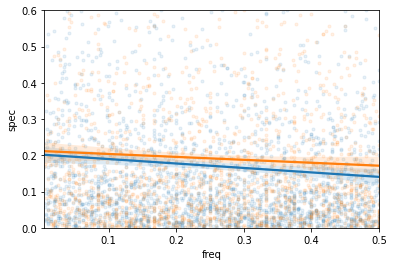

In [157]:
g = sns.regplot(data=fft_df[fft_df.speaker == 'g'], x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1})
g = sns.regplot(data=fft_df[fft_df.speaker == 'f'], x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1})
if col == "xu_h":
    g.axes.set_ylim(0,0.6)
else:
    g.axes.set_ylim(0,50)
g


comparison with random noise

In [136]:
SPEC_PATH = "/Users/neako/Documents/Cours-MasCo/PhD/tools/githubs/IT/time-series-analysis-master/Python"
sys.path.append(SPEC_PATH)
from spectrum import * # spec_pg

In [158]:
def compare_with_noise(df:pd.DataFrame, fft_df:pd.DataFrame=None, col_data:str='xu_h', 
        spgram = partial(spec_pgram, taper=0, plot=False, log='no'), n_noise:int=1000 
    ):
    summary = df[col_data].describe()
    print(summary)
    s = np.random.normal(summary['mean'], summary['std'], n_noise)
    s_ent = pd.DataFrame(spgram(s))[['freq','spec']]
    s_ent['origin'] = 'white_noise'

    if fft_df is not None:
        tmp = fft_df[['file','speaker','freq','spec']]
        tmp['origin'] = 'data'
        tmp = pd.concat([tmp,s_ent], axis=0).reset_index(drop=True)
        return tmp
    else:
        return s_ent

In [159]:
s_ent = compare_with_noise(res[(res.model == 'reference')])
s_ent.head()

count    7932.000000
mean        1.000000
std         0.297928
min         0.277486
25%         0.829930
50%         0.968505
75%         1.145338
max         2.697803
Name: xu_h, dtype: float64


,freq,spec,origin
0,0.001,0.061465,white_noise
1,0.002,0.047409,white_noise
2,0.003,0.094684,white_noise
3,0.004,0.067017,white_noise
4,0.005,0.049022,white_noise


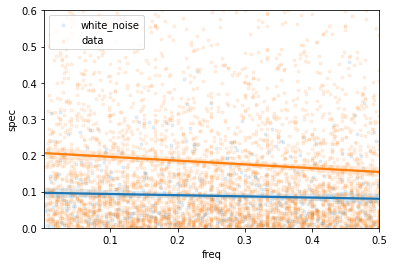

In [166]:
sns.regplot(data=s_ent, x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1}, label='white_noise')
g = sns.regplot(data=fft_df, x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1}, label='data')
if col == "xu_h":
    g.axes.set_ylim(0,0.6)
else:
    g.axes.set_ylim(0,50)
g.legend(loc=2)

(array([[1.44773701e-01],
        [2.83962934e-01],
        [2.67830292e-01],
        [2.42908193e-01],
        [2.11804388e-01],
        [1.77561543e-01],
        [1.43201746e-01],
        [1.11317206e-01],
        [8.37786038e-02],
        [6.16015281e-02],
        [4.49741845e-02],
        [3.34156599e-02],
        [2.60112946e-02],
        [2.16644811e-02],
        [1.93121808e-02],
        [1.80704562e-02],
        [1.72997955e-02],
        [1.66011425e-02],
        [1.57672129e-02],
        [1.47176578e-02],
        [1.34418159e-02],
        [1.19624378e-02],
        [1.03221649e-02],
        [8.58553696e-03],
        [6.84519034e-03],
        [5.22199779e-03],
        [3.85373495e-03],
        [2.87303196e-03],
        [2.38043458e-03],
        [2.42072302e-03],
        [2.96977944e-03],
        [3.93597114e-03],
        [5.17565594e-03],
        [6.51857065e-03],
        [7.79666929e-03],
        [8.86985665e-03],
        [9.64371444e-03],
        [1.00769556e-02],
        [1.0

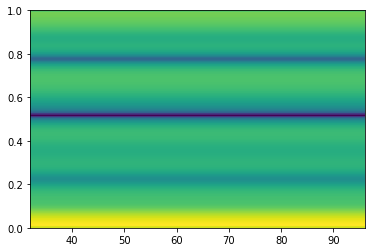

In [147]:
plt.specgram(tmp[tmp.speaker == 'f'].normalised_h, NFFT=256, Fs=2, Fc=0)